# 라이브러리 불러오기

- 라이브러리 불러오기 및 모델 실험을 시각화할 wandb 연동

In [2]:
# 라이브러리 가져오기
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from numpy.random import seed
import wandb
from wandb.keras import WandbCallback 

In [3]:
wandb.login(key = 'b70c8335b10511e0a72863f129e1113af445e9ae') 

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

# 데이터 불러오기

In [4]:
# 훈련 데이터 클래스 폴더 확인

image_train_data = '/aiffel/aiffel/skinset2/train'
train_df = pd.DataFrame(os.listdir(image_train_data),columns=['train'])
train_df

,train
0,Acne
1,Atopic Dermatitis
2,Benign Keratosis-like Lesions (BKL)
3,Eczema Photos
4,Warts Molluscum and other Viral Infections
5,Seborrheic Keratoses and other Benign Tumors
6,Melanoma
7,Psoriasis pictures Lichen Planus and related d...
8,Basal Cell Carcinoma (BCC)
9,Tinea Ringworm Candidiasis and other Fungal In...


In [5]:
# 검증 데이터 클래스 폴더 확인

image_val_data = '/aiffel/aiffel/skinset2/val'
val_df = pd.DataFrame(os.listdir(image_val_data),columns=['val'])
val_df

,val
0,Acne
1,Atopic Dermatitis
2,Benign Keratosis-like Lesions (BKL)
3,Eczema Photos
4,Warts Molluscum and other Viral Infections
5,Seborrheic Keratoses and other Benign Tumors
6,Melanoma
7,Psoriasis pictures Lichen Planus and related d...
8,Basal Cell Carcinoma (BCC)
9,Tinea Ringworm Candidiasis and other Fungal In...


In [6]:
# 평가 데이터 클래스 폴더 확인

image_test_data = '/aiffel/aiffel/skinset2/test'
test_df = pd.DataFrame(os.listdir(image_test_data ),columns=['test'])
test_df

,test
0,Acne
1,Atopic Dermatitis
2,Benign Keratosis-like Lesions (BKL)
3,Eczema Photos
4,Warts Molluscum and other Viral Infections
5,Seborrheic Keratoses and other Benign Tumors
6,Melanoma
7,Psoriasis pictures Lichen Planus and related d...
8,Basal Cell Carcinoma (BCC)
9,Tinea Ringworm Candidiasis and other Fungal In...


# 데이터 불러오기

- 'tf.keras.preprocessing.image_dataset_from_directory 함수는 디스크에서 이미지 데이터를 로드하고 이를 모델에 공급하기 위한 TensorFlow 데이터셋을 생성하는 데 사용. 이 함수를 사용하면 디렉토리 구조에서 이미지를 자동으로 로드하고 레이블링할 수 있음

In [7]:
# 데이터 불러오기 / 훈련 및 평가 나누기

batch_size = 32
target_size = (224,224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_train_data,
    seed=123,
    shuffle=True,
    image_size=target_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_val_data,
    seed=123,
    shuffle=True,
    image_size=target_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_test_data,
    seed=123,
    shuffle=True,
    image_size=target_size,
    batch_size=batch_size,
)

Found 27126 files belonging to 10 classes.
Found 2640 files belonging to 10 classes.
Found 2657 files belonging to 10 classes.


In [8]:
# 훈련 데이터 라벨 확인

class_names = train_ds.class_names
for idx, name in enumerate(class_names):
    print(f"라벨{idx}에 해당하는 클래스 : {name}")

라벨0에 해당하는 클래스 : Acne
라벨1에 해당하는 클래스 : Atopic Dermatitis
라벨2에 해당하는 클래스 : Basal Cell Carcinoma (BCC)
라벨3에 해당하는 클래스 : Benign Keratosis-like Lesions (BKL) 
라벨4에 해당하는 클래스 : Eczema Photos
라벨5에 해당하는 클래스 : Melanoma
라벨6에 해당하는 클래스 : Psoriasis pictures Lichen Planus and related diseases
라벨7에 해당하는 클래스 : Seborrheic Keratoses and other Benign Tumors
라벨8에 해당하는 클래스 : Tinea Ringworm Candidiasis and other Fungal Infections
라벨9에 해당하는 클래스 : Warts Molluscum and other Viral Infections


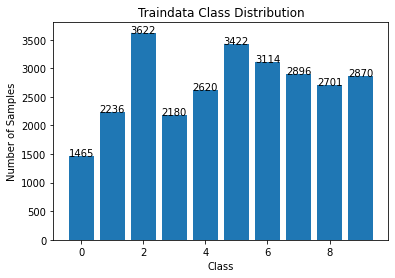

In [9]:
# 훈련 데이터 분포

# 클래스별 샘플 수를 저장할 딕셔너리 생성
class_distribution = {i: 0 for i in range(len(train_ds.class_names))}

# 훈련 데이터셋을 순회하면서 각 클래스별 샘플 수 세기
for images, labels in train_ds:
    for label in labels.numpy():  # TensorFlow Tensor를 numpy 배열로 변환
        class_distribution[label] += 1

# 클래스별 분포를 히스토그램으로 시각화
plt.bar(class_distribution.keys(), class_distribution.values())

# 각 막대 위에 숫자 표시
for label, count in class_distribution.items():
    plt.text(label, count, str(count), ha='center')
    
# 그래프 제목 및 축 라벨 설정
plt.title('Traindata Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 그래프 출력
plt.show()

In [10]:
# 검증 데이터 라벨 확인

class_names = val_ds.class_names
for idx, name in enumerate(class_names):
    print(f"라벨{idx}에 해당하는 클래스 : {name}")

라벨0에 해당하는 클래스 : Acne
라벨1에 해당하는 클래스 : Atopic Dermatitis
라벨2에 해당하는 클래스 : Basal Cell Carcinoma (BCC)
라벨3에 해당하는 클래스 : Benign Keratosis-like Lesions (BKL) 
라벨4에 해당하는 클래스 : Eczema Photos
라벨5에 해당하는 클래스 : Melanoma
라벨6에 해당하는 클래스 : Psoriasis pictures Lichen Planus and related diseases
라벨7에 해당하는 클래스 : Seborrheic Keratoses and other Benign Tumors
라벨8에 해당하는 클래스 : Tinea Ringworm Candidiasis and other Fungal Infections
라벨9에 해당하는 클래스 : Warts Molluscum and other Viral Infections


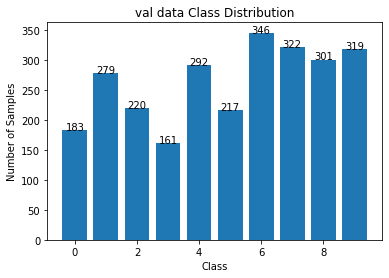

In [11]:
# 검증 데이터 분포

# 클래스별 샘플 수를 저장할 딕셔너리 생성
class_distribution = {i: 0 for i in range(len(val_ds.class_names))}

# 훈련 데이터셋을 순회하면서 각 클래스별 샘플 수 세기
for images, labels in val_ds:
    for label in labels.numpy():  # TensorFlow Tensor를 numpy 배열로 변환
        class_distribution[label] += 1

# 클래스별 분포를 히스토그램으로 시각화
plt.bar(class_distribution.keys(), class_distribution.values())

# 각 막대 위에 숫자 표시
for label, count in class_distribution.items():
    plt.text(label, count, str(count), ha='center')
    
# 그래프 제목 및 축 라벨 설정
plt.title('val data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 그래프 출력
plt.show()

In [12]:
# 평가 데이터 라벨 확인

class_names = test_ds.class_names
for idx, name in enumerate(class_names):
    print(f"라벨{idx}에 해당하는 클래스 : {name}")

라벨0에 해당하는 클래스 : Acne
라벨1에 해당하는 클래스 : Atopic Dermatitis
라벨2에 해당하는 클래스 : Basal Cell Carcinoma (BCC)
라벨3에 해당하는 클래스 : Benign Keratosis-like Lesions (BKL) 
라벨4에 해당하는 클래스 : Eczema Photos
라벨5에 해당하는 클래스 : Melanoma
라벨6에 해당하는 클래스 : Psoriasis pictures Lichen Planus and related diseases
라벨7에 해당하는 클래스 : Seborrheic Keratoses and other Benign Tumors
라벨8에 해당하는 클래스 : Tinea Ringworm Candidiasis and other Fungal Infections
라벨9에 해당하는 클래스 : Warts Molluscum and other Viral Infections


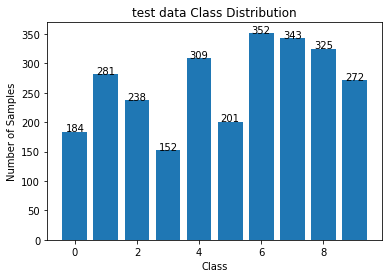

In [13]:
# 평가 데이터 분포

# 클래스별 샘플 수를 저장할 딕셔너리 생성
class_distribution = {i: 0 for i in range(len(test_ds.class_names))}

# 훈련 데이터셋을 순회하면서 각 클래스별 샘플 수 세기
for images, labels in test_ds:
    for label in labels.numpy():  # TensorFlow Tensor를 numpy 배열로 변환
        class_distribution[label] += 1

# 클래스별 분포를 히스토그램으로 시각화
plt.bar(class_distribution.keys(), class_distribution.values())

# 각 막대 위에 숫자 표시
for label, count in class_distribution.items():
    plt.text(label, count, str(count), ha='center')
    
# 그래프 제목 및 축 라벨 설정
plt.title('test data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 그래프 출력
plt.show()

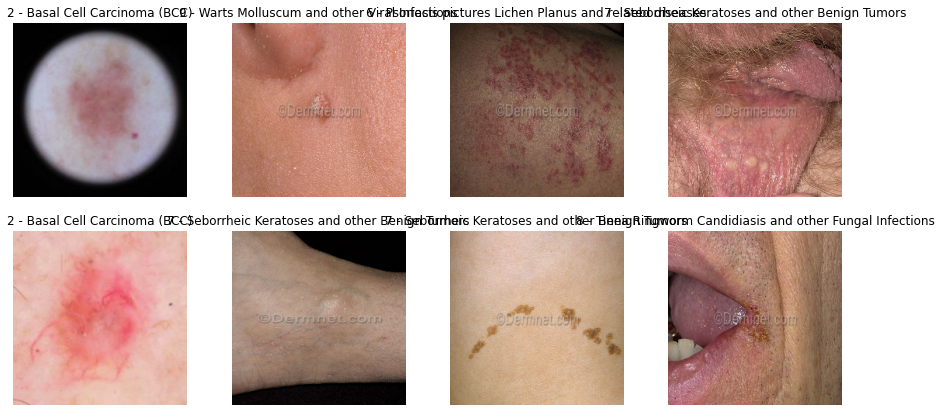

In [14]:
# 이미지 확인

plt.figure(figsize=(15, 30))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{labels[i]} - {class_names[labels[i]]}")
        plt.axis("off")

In [15]:
# 평가데이터 넘파이 형태로 변환 후 평가

# Convert MapDataset to NumPy arrays
test_data_numpy = test_ds.unbatch().as_numpy_iterator()

# Extract images and labels
x_test, y_test = zip(*test_data_numpy)

# Convert to NumPy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# shape
print(x_test.shape, y_test.shape)

(2657, 224, 224, 3) (2657,)


# 모델 훈련

- ResNet50 pretrained model로 훈련
- ReduceLROnPlateau 콜백 함수: 이 콜백 함수는 검증 손실(val_loss)을 모니터링하고, 지정된 팩터(factor)에 따라 학습률(learning rate)을 동적으로 조절. 팩터는 검증 손실이 개선되지 않을 때 학습률을 줄이는 비율을 결정. 여기서는 factor = 0.2로 설정되어 있으므로, 검증 손실이 개선되지 않을 때마다 학습률이 0.2배씩 감소. patience는 학습률을 조절하기 전에 지켜볼 에폭(epoch)의 수를 나타냄. min_lr은 학습률의 하한값을 의미
- EarlyStopping 콜백 함수: 이 콜백 함수는 검증 손실(val_loss)을 모니터링하고, 지정된 횟수의 에폭(patience) 동안 개선이 없을 경우 조기 종료를 수행. 즉, 검증 손실이 더 이상 개선되지 않을 때 모델 학습을 중지. patience는 조기 종료를 결정하기 위한 에폭의 수를 나타냄. min_delta는 개선으로 간주되기 위한 최소 손실 변화를 의미.
- 실험결과(classification report, confusion matrix 등)은 wandb를 통해 출력

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4, min_lr = 1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

wandb: Currently logged in as: swl7359 (skinaiffel). Use `wandb login --relogin` to force relogin


94781440/94765736 [==============================] - 1s 0us/step


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/46
848/848 [==============================] - 100s 111ms/step - loss: 1.5011 - accuracy: 0.4744 - val_loss: 1.1949 - val_accuracy: 0.5705


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 2/46
848/848 [==============================] - 92s 108ms/step - loss: 1.0405 - accuracy: 0.6229 - val_loss: 1.0255 - val_accuracy: 0.6345
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 3/46
848/848 [==============================] - 92s 108ms/step - loss: 0.9183 - accuracy: 0.6680 - val_loss: 0.9484 - val_accuracy: 0.6614
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 4/46
848/848 [==============================] - 92s 108ms/step - loss: 0.8476 - accuracy: 0.6976 - val_loss: 0.8977 - val_accuracy: 0.6773
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.4s


Epoch 5/46
848/848 [==============================] - 92s 108ms/step - loss: 0.7962 - accuracy: 0.7172 - val_loss: 0.8597 - val_accuracy: 0.6958
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 6/46
848/848 [==============================] - 92s 108ms/step - loss: 0.7558 - accuracy: 0.7324 - val_loss: 0.8238 - val_accuracy: 0.7117
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 7/46
848/848 [==============================] - 92s 108ms/step - loss: 0.7220 - accuracy: 0.7469 - val_loss: 0.7996 - val_accuracy: 0.7197 - accura - ETA: 1:06 - loss: 0.731 - ETA: 1:05 - loss: 0.7296 - 
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 8/46
848/848 [==============================] - 92s 108ms/step - loss: 0.6930 - accuracy: 0.7593 - val_loss: 0.7791 - val_accuracy: 0.7258
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 9/46
848/848 [==============================] - 92s 108ms/step - loss: 0.6670 - accuracy: 0.7720 - val_loss: 0.7584 - val_accuracy: 0.7299
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 10/46
848/848 [==============================] - 92s 108ms/step - loss: 0.6438 - accuracy: 0.7822 - val_loss: 0.7378 - val_accuracy: 0.7364acy: 0.77 - ETA: 1:09 - loss: - ETA: 1:08 - loss: 0.6496 - accuracy:  - ETA: 1:08 - loss: 0.650 -
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 11/46
848/848 [==============================] - 92s 108ms/step - loss: 0.6225 - accuracy: 0.7908 - val_loss: 0.7242 - val_accuracy: 0.7462
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 12/46
848/848 [==============================] - 92s 108ms/step - loss: 0.6025 - accuracy: 0.7992 - val_loss: 0.7101 - val_accuracy: 0.7473
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 13/46
848/848 [==============================] - 92s 108ms/step - loss: 0.5842 - accuracy: 0.8075 - val_loss: 0.6963 - val_accuracy: 0.7530
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 14/46
848/848 [==============================] - 92s 108ms/step - loss: 0.5673 - accuracy: 0.8150 - val_loss: 0.6847 - val_accuracy: 0.7580racy:  - ETA: 1s - los
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 15/46
848/848 [==============================] - 92s 108ms/step - loss: 0.5513 - accuracy: 0.8216 - val_loss: 0.6712 - val_accuracy: 0.7625
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 16/46
848/848 [==============================] - 92s 108ms/step - loss: 0.5360 - accuracy: 0.8277 - val_loss: 0.6623 - val_accuracy: 0.7663
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 17/46
848/848 [==============================] - 92s 108ms/step - loss: 0.5216 - accuracy: 0.8343 - val_loss: 0.6515 - val_accuracy: 0.76939 - los - ETA: 1:08 - loss: 0.5241 - accuracy: 0.83 - ETA:  - ETA: 1:06 - loss: 0.5239 -  - ETA: 1 - ETA: 59s - loss: 0.5208 - accuracy - ETA: 59s - loss: 0.5201 - accuracy: 0. - ETA: 58s - loss: 0.5187 - accuracy: 0 - ETA: 58s - loss: 0.5198  -
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 18/46
848/848 [==============================] - 92s 108ms/step - loss: 0.5079 - accuracy: 0.8404 - val_loss: 0.6409 - val_accuracy: 0.7735
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.0s


Epoch 19/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4949 - accuracy: 0.8465 - val_loss: 0.6307 - val_accuracy: 0.7788
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 20/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4820 - accuracy: 0.8511 - val_loss: 0.6231 - val_accuracy: 0.7792
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 21/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4697 - accuracy: 0.8571 - val_loss: 0.6120 - val_accuracy: 0.7886
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 22/46
848/848 [==============================] - 96s 113ms/step - loss: 0.4583 - accuracy: 0.8608 - val_loss: 0.6045 - val_accuracy: 0.7917
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 23/46
848/848 [==============================] - 149s 173ms/step - loss: 0.4469 - accuracy: 0.8649 - val_loss: 0.5964 - val_accuracy: 0.7932
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 24/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4361 - accuracy: 0.8702 - val_loss: 0.5887 - val_accuracy: 0.7955
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.0s


Epoch 25/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4255 - accuracy: 0.8740 - val_loss: 0.5803 - val_accuracy: 0.7996
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 26/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4155 - accuracy: 0.8781 - val_loss: 0.5741 - val_accuracy: 0.8030
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 27/46
848/848 [==============================] - 92s 108ms/step - loss: 0.4054 - accuracy: 0.8835 - val_loss: 0.5676 - val_accuracy: 0.8027
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 28/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3958 - accuracy: 0.8870 - val_loss: 0.5585 - val_accuracy: 0.8064
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 29/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3864 - accuracy: 0.8903 - val_loss: 0.5535 - val_accuracy: 0.8095
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 30/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3775 - accuracy: 0.8940 - val_loss: 0.5478 - val_accuracy: 0.8140  - ETA: 1:03 - loss: 0.3793 - accu - ETA: 1:03 - l - ETA: 1:01 - loss: 0.3765 - accuracy: 0. - ETA: 1:01 - loss
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 31/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3687 - accuracy: 0.8982 - val_loss: 0.5397 - val_accuracy: 0.8170ss: 0.3691 - accu - E - ETA: 1:02 - - ETA: 1:00 - loss: 0.3 - ETA: 59s - loss:
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 32/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3598 - accuracy: 0.9022 - val_loss: 0.5364 - val_accuracy: 0.8193ss: - ETA: 1:07 - loss: 0.3557 - accuracy: 0. - ETA: 1:07 - loss: 0.3573 -  - ETA: 1:06 - loss: 0.3580 - accuracy: 0.90 - ETA: 1:06 - loss: 0.358 - ETA: 1:05 - loss: 0.3604 - accuracy: 0.90 - ETA: 1:05 - loss: 0.3606 - accuracy: 0.90 - ETA: 1:05 - loss: 0.3603 - accurac
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 33/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3518 - accuracy: 0.9054 - val_loss: 0.5296 - val_accuracy: 0.8235
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 34/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3434 - accuracy: 0.9095 - val_loss: 0.5227 - val_accuracy: 0.8273: 0.3431 - accuracy: 0. - ETA: 1:06 - loss: 0.3420 - accura - ETA: 1:05 - l - ETA: 1:02 - loss: 0.3426 - ac - ETA: 1:01 - loss: 0.3421 - accu - ETA: 1:00 - loss: - ETA: 59s - loss: 0.3417 - accuracy: 0.91 - ETA: 59s - loss: 0.3421 - accura - ETA: 58s - loss: 0.3425 - accuracy: 0.912 - ETA: 58s - loss: 0.3430 - ac
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 35/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3357 - accuracy: 0.9130 - val_loss: 0.5176 - val_accuracy: 0.8277
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 36/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3278 - accuracy: 0.9156 - val_loss: 0.5122 - val_accuracy: 0.8303
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 37/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3200 - accuracy: 0.9188 - val_loss: 0.5062 - val_accuracy: 0.8333
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 0.9s


Epoch 38/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3133 - accuracy: 0.9217 - val_loss: 0.5014 - val_accuracy: 0.8360
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 39/46
848/848 [==============================] - 92s 108ms/step - loss: 0.3055 - accuracy: 0.9253 - val_loss: 0.4979 - val_accuracy: 0.8364A: 1:06 - loss: - ETA: 1:04 - loss: 0.3061 - accuracy:  - ETA: 1:04 - loss: 0.3058 - ac - ETA: 1:04 - loss: 0.3063 - accuracy: 0.92 - ETA: 1:03 - loss: 0.30
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 40/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2988 - accuracy: 0.9274 - val_loss: 0.4921 - val_accuracy: 0.8367- loss: 0.2959 - ac - ETA: 1:07 - loss: 0.2977 - accurac
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 41/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2919 - accuracy: 0.9298 - val_loss: 0.4895 - val_accuracy: 0.8383
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 42/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2851 - accuracy: 0.9321 - val_loss: 0.4855 - val_accuracy: 0.8386:08 - loss: 0.2834 - ac - ETA: 1:07 - loss: 0.2841 - accuracy: 0.93 - ETA: 1:07 - loss: 0.2844 - accuracy - ETA: 1:06 - loss: 0 - ETA: 1:05 - loss: 0.2852 
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


Epoch 43/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2788 - accuracy: 0.9342 - val_loss: 0.4779 - val_accuracy: 0.8458 1:06 - loss: 0.2792 - accuracy: 0.93 - ETA: 1:06 - loss: 0.2787 - accuracy: 0.93 - ETA: 1:05 - loss: 0.2787 - accuracy: 0.93 - ETA: 1:05 - loss: 0.2785
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.2s


Epoch 44/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2722 - accuracy: 0.9372 - val_loss: 0.4728 - val_accuracy: 0.8473
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.0s


Epoch 45/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2662 - accuracy: 0.9393 - val_loss: 0.4687 - val_accuracy: 0.8496A: 1:07 - loss: 0.2639 - accuracy: 0.94 - ETA: 1:07 - loss: 0.2638 - accuracy: 0. - ETA: 1:06 - loss: 0.2635 -  - ETA: 1:06 - loss: 0.2666 - ac - ETA: 1 - ETA: 59s - loss: 0
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.0s


Epoch 46/46
848/848 [==============================] - 92s 108ms/step - loss: 0.2600 - accuracy: 0.9414 - val_loss: 0.4680 - val_accuracy: 0.8447
INFO:tensorflow:Assets written to: /aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best/assets


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/cv_study/study05/wandb/run-20240408_184545-iiduotmz/files/model-best)... Done. 1.1s


84/84 [==============================] - 8s 100ms/step - loss: 0.4522 - accuracy: 0.8581
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       184
           1       0.96      0.93      0.95       281
           2       0.84      0.85      0.84       238
           3       0.76      0.74      0.75       152
           4       0.82      0.87      0.84       309
           5       0.96      0.96      0.96       201
           6       0.82      0.82      0.82       352
           7       0.79      0.92      0.85       343
           8       0.88      0.84      0.86       325
           9       0.87      0.78      0.82       272

    accuracy                           0.86      2657
   macro avg       0.86      0.85      0.86      2657
weighted avg       0.86      0.86      0.86      2657



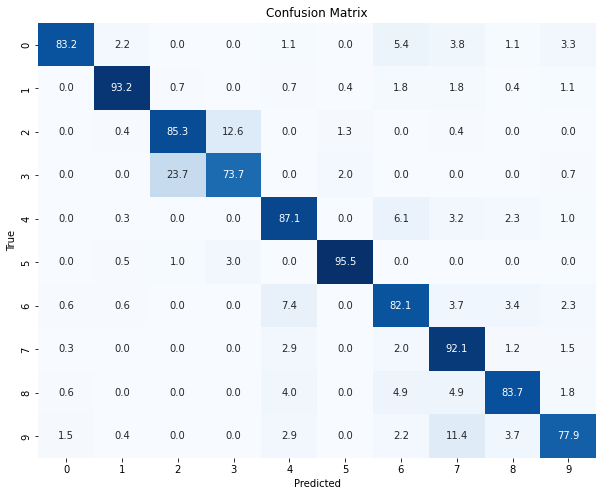

Test Accuracy,▁
Test Error,▁
accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Test Accuracy,85.81
Test Error,14.19
accuracy,0.94138
best_epoch,45


In [19]:
wandb.init(entity='skinaiffel',
           project='study05',
           name='ResNet50-1',
           config={
               "input": (224, 224, 3),
               "activation": "relu",
               "learning_rate": 1e-5,
               "loss": "sparse_categorical_crossentropy",
               "epochs" : 46,
               "metrics": 'accuracy'
           })

config = wandb.config

num_classes = 10
model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(input_shape=config.input, include_top=False, weights='imagenet')
pretrained_model.trainable = False
inputs = pretrained_model.input
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss=config.loss,
              metrics=config.metrics)

model.fit(train_ds,
          epochs=config.epochs,
          validation_data=val_ds,
          callbacks=[
              WandbCallback(validation_data=val_ds, 
                            monitor='val_loss',
                            labels = np.unique(y_test),
                            predictions = 10,
                            input_type = "images"),
              reduce_lr, early_stop])

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
wandb.log({"Test Accuracy" : round(test_accuracy * 100, 2),
            "Test Error" : round((1 - test_accuracy) * 100, 2)})


pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)
wandb.log({"confusion matrix" : wandb.plot.confusion_matrix(probs=None,
                                                            y_true=y_test,
                                                            preds=pred_classes, 
                                                            class_names=np.unique(y_test))})

report = classification_report(y_test, pred_classes, output_dict=True)
report2 = classification_report(y_test, pred_classes)
df_report = pd.DataFrame(report).transpose()
wandb.log({"classification_report": wandb.Table(dataframe=df_report)})
print(report2)


# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, pred_classes)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.1f', cmap='Blues', 
            cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

wandb.finish()